In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}<style>"))

# Model1

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import json
import numpy as np
import random
from tqdm import tqdm

# Load data

In [4]:
from sklearn.utils import shuffle
def read_paths(dataset_path, list_path):
    imagepaths = []
    labelpaths = []
    for path in open(list_path):
        md5 = path.split('.')[0]
        imagepaths.append(dataset_path + "images/%s.jpg"%md5)
        labelpaths.append(dataset_path + "spline_labels/%s.json"%md5)
    return imagepaths, labelpaths

val_set_path = '/data/mc_data/MLDC/data/val/'
val_list_path = '/data/mc_data/MLDC/data/val/list.txt'
val_image_paths, val_label_paths = read_paths(val_set_path, val_list_path)

train_set_path = '/data/mc_data/MLDC/data/train_2w/'
train_list_path = '/home/mc16/train_2w_list.txt'
train_image_paths, train_label_paths = read_paths(train_set_path, train_list_path)

In [5]:
def get_label_json(label_paths):
    labels_json = []
    for labelpath in tqdm(label_paths):
        with open(labelpath, 'r') as f:
            data = json.load(f)
            labels_json.append(data)
    return labels_json
val_labels_json = get_label_json(val_label_paths)
train_labels_json = get_label_json(train_label_paths)

100%|██████████| 20000/20000 [00:39<00:00, 510.23it/s]


In [6]:
def get_label(labels_json):
    labels = np.zeros((len(labels_json), 224, 224), np.uint8)
    for i in tqdm(xrange(len(labels_json))):
        for j,line in enumerate(labels_json[i].values()[0]):
            for k, point in enumerate(line):
                x, y = int(float(point['x']+.5)), int(float(point['y']+0.5))
                if(x>223):x=223
                if(y>223):
                    y=223
                labels[i][y][x] = 1
                if x < 223: labels[i][y][x+1] = 1
                if x > 0  : labels[i][y][x-1] = 1
                if y < 223: labels[i][y+1][x] = 1
                if y > 0  : labels[i][y-1][x] = 1
                    
    return labels
train_labels = get_label(train_labels_json)
val_labels = get_label(val_labels_json)

100%|██████████| 2015/2015 [00:03<00:00, 619.25it/s]


In [7]:
def generator(dataset_path, list_path, labels, batch_size, data_shape):
    # read md5 for all image and label
    md5s = []
    for path in open(list_path):
        md5s.append(path.split('.')[0])
    md5s = np.array(md5s)
    
    # generate and preprocess image and label by batch_size
    while True:
        random.seed(batch_size)
        batch_indices = np.random.randint(0, len(labels), batch_size)
        batch_md5s = md5s[batch_indices]
        batch_labels = np.array(labels)[batch_indices]
        batch_labels = batch_labels.reshape(batch_size, -1)
        batch_images = []
        for md5 in batch_md5s:
            img = plt.imread(dataset_path + "images/%s.jpg"%md5)
            img = cv2.resize(img, (data_shape,data_shape), interpolation=cv2.INTER_CUBIC)
            batch_images.append(img)

        yield np.array(batch_images), batch_labels


# Model

In [ ]:
    from keras.applications.resnet50 import preprocess_input, decode_predictions
    from keras.applications.resnet50 import ResNet50
    path='/home/mc16/keras_pre_h5/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
#     with tf.device('/cpu:0'):
    base_net=ResNet50(include_top = False,weights='imagenet')
    base_net.load_weights(path)
    base_net.summary()

In [8]:
import pydot
import keras
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Lambda, Cropping2D, Dense, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import RMSprop, Adam
from keras.utils import multi_gpu_model
from keras.preprocessing import image
from keras import Input

In [9]:
from keras import backend as KB
import keras.backend.tensorflow_backend as KBT
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.Session(config=config)
KB.set_session(sess)

In [10]:
DATA_SHAPE = 512

In [11]:
def vgg16(input_shape):
    from keras.applications.vgg16 import preprocess_input, decode_predictions
    from keras.applications.vgg16 import VGG16
    path='/home/mc16/download_models/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
#     with tf.device('/cpu:0'):
    base_net=VGG16(include_top=False,weights='imagenet',input_shape=input_shape)
    base_net.load_weights(path)
    pre_net = Model(inputs=base_net.input, outputs=base_net.get_layer('block2_conv2').output)
    for layer in pre_net.layers: 
        layer.trainable = False
    return pre_net

def extrate_net(input, pre_net):
#     with tf.device('/cpu:0'):
    features = pre_net(input)
    poll1 = MaxPooling2D(pool_size=(7, 7), strides=(1,1), padding='valid')(features)
    conv1 = Conv2D(128, (9, 9), strides=(1,1), padding='valid')(poll1)
    conv2 = Conv2D(64, (9, 9), strides=(1,1), padding='valid')(conv1)
    conv3 = Conv2D(1, (9, 9), strides=(1,1), padding='valid')(conv2)
    sample_features = AveragePooling2D(pool_size=(3, 3), strides=(1,1), padding='valid')(conv3)
    temp = Flatten()(sample_features)
    extra_net = Model(inputs=input, outputs=temp)
    return extra_net

with tf.device('/cpu:0'):
    input_shape = (DATA_SHAPE,DATA_SHAPE,3)
    X = Input(shape=input_shape)
    vgg_net = vgg16(input_shape)
    vgg_net.summary()
    extra_net = extrate_net(X, vgg_net)
extra_net.summary()
parallel_extra_net = multi_gpu_model(extra_net,gpus=8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
Total params: 260,160
Trainable params: 0
Non-trainable params: 260,160
_________________________________________________________________
____

# Train

In [12]:
%%time
BATCH_SIZE = 64
train_generator = generator(train_set_path, train_list_path, train_labels, BATCH_SIZE, DATA_SHAPE)
valid_generator = generator(val_set_path, val_list_path, val_labels, BATCH_SIZE, DATA_SHAPE)

LEARNING_RATE = 5e-4
EPOCHS = 1
STEP_PER_EPOCH = int(len(train_image_paths)/BATCH_SIZE)
VALIDATION_STEPS = int(len(val_image_paths)/BATCH_SIZE)
parallel_extra_net.compile(loss='mse', optimizer=Adam(LEARNING_RATE))
parallel_extra_net.fit_generator(train_generator, 
                    verbose=1,
                    validation_data=valid_generator,
                    steps_per_epoch=STEP_PER_EPOCH,
                    epochs = EPOCHS,
                    validation_steps=10) # VALIDATION_STEPS

Epoch 1/1
312/312 [==============================] - 2347s 8s/step - loss: 38880725.4554 - val_loss: 66638.7563
CPU times: user 54min 19s, sys: 3min 42s, total: 58min 2s
Wall time: 39min 7s


In [20]:
import gc
# del extra_net
KB.clear_session()
gc.collect()

188

### save trained model

In [16]:
# 保存整个模型为.h5文件
extra_net.save('model1.h5')
# 保存模型的结构和权重分别为.json和.h5
model_json = extra_net.to_json()
open('model1_structure.json','w').write(model_json)
extra_net.save_weights('model1_weights.h5')

# Test

In [34]:
# load trained model
from keras.models import model_from_json
from keras.models import load_model
# 从.h5文件载入整个模型
model = load_model('model1.h5')
# 从.json和.h5载入模型的结构和权重
# model = model_from_json(open('model1_structure.json').read())
# model.load_weights('model1_weights.h5')

/home/mc16/.local/lib/python2.7/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [35]:
# 2029 images in test0
def detect_points(img, model):
    img = cv2.resize(img, (512,512))
    img = np.expand_dims(img,axis=0)
    points = model.predict(img) # 1x
    points = points.reshape(224,224)
    return points
    
def detect_points_list(test_set_path, test_md5_paths, model):
    points_list = []
    for path in tqdm(test_md5_paths):
        md5 = path.split('.')[0]
        img = plt.imread(test_set_path + md5 +'.jpg')
        points = detect_points(img, model)
        points_list.append(points)
    return points_list
        
test_set_path = '/data/mc_data/MLDC/data/test0/images/' 
test_md5_paths = open('/home/mc16/test0_list.txt','r').readlines()
points_list = detect_points_list(test_set_path, test_md5_paths, model)
print(len(points_list), points_list[0].shape, points_list[0].dtype) 

100%|██████████| 2029/2029 [06:53<00:00,  4.90it/s]

(2029, (224, 224), dtype('float32'))


In [36]:
print(points_list[0])

[[-320.21912   -373.693     -359.3365    ... -167.96603     12.392836
   117.6575   ]
 [-394.92908   -350.11652   -266.72974   ... -275.1411     -88.2591
    48.696175 ]
 [-289.44934   -162.1791     -60.544662  ... -294.99902   -119.81266
    21.365538 ]
 ...
 [  15.388395   194.19325    342.34772   ...   17.833336    -6.3066006
   -42.922813 ]
 [ 136.06937    360.9732     520.4711    ...    8.08568    -13.879237
   -48.70966  ]
 [ 275.57727    488.15173    636.86035   ...   28.148281    14.501653
   -11.422573 ]]


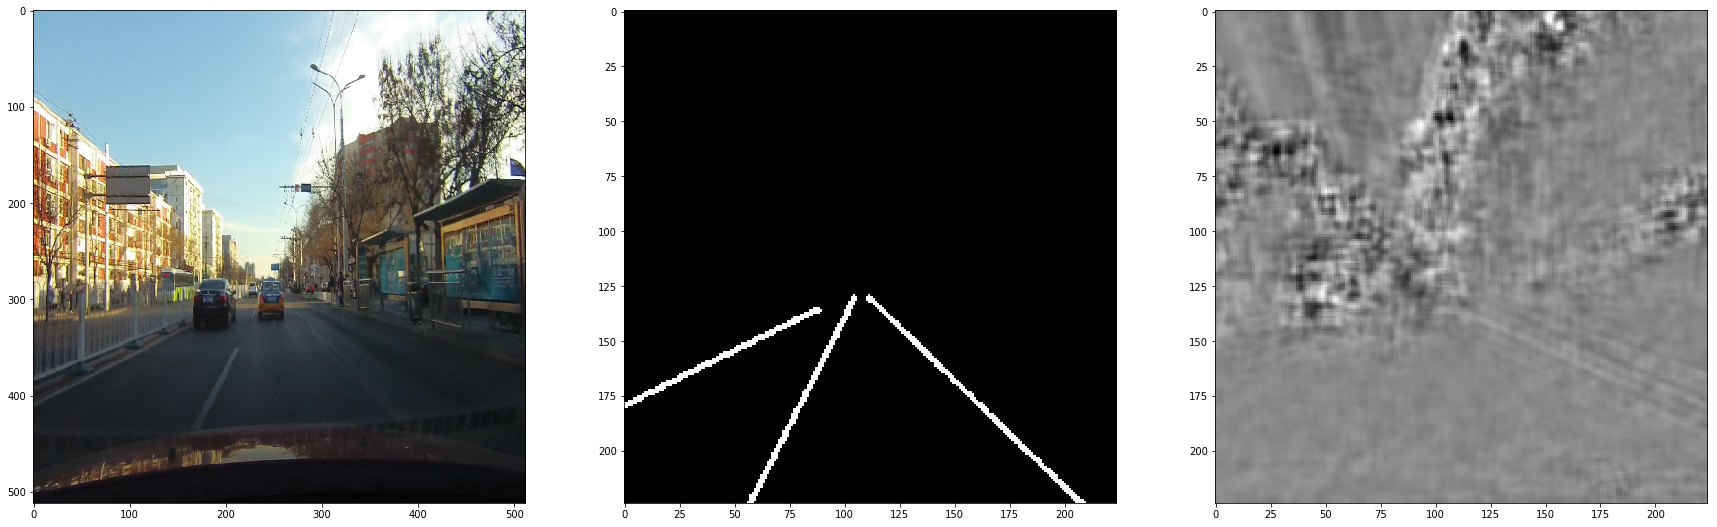

In [38]:
# show the detected points on a valid image
test_index = random.randint(0, len(val_labels))
test_label = val_labels[test_index]
test_img = plt.imread(val_image_paths[test_index])
resize_test_img = cv2.resize(test_img,(512,512))
test_points = detect_points(resize_test_img, model)
fig, axs = plt.subplots(1, 3, figsize=(30,30)) 
axs[0].imshow(resize_test_img)
axs[1].imshow(test_label,cmap='gray')
axs[2].imshow(points_list[test_index],cmap='gray')
plt.show()

# Point Cluster

# Lane Line Fitting

# Save as .json